# Clasificación de señales de tráfico usando TensorFlow y Keras

Instalación de dependencias:

In [ ]:
!pip install tensorflow==2.10 opencv-python matplotlib

In [ ]:
!pip list

In [3]:
import tensorflow as t
import os

import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

# Importar dependencias para el modelo
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [4]:
gpus = t.config.experimental.list_physical_devices('GPU')
len(gpus) # 1 -> GPU disponible

1

Funciones sobre imágenes:

In [5]:
data_dir = 'data'

# Mostrar una imagen con matplotlib usando cv2 para corregir los colores
def mostrarImagen(img: cv2.typing.MatLike):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# Ejemplo de lectura de imagen
img = cv2.imread(os.path.join(data_dir, 'stop-sign', '1c56eb1de271aaca19a8f081dca6e5eb.jpg'))
mostrarImagen(img)

Carga de las imágenes:
  1. Eliminar imágenes que no tengan un formato comprendido entre los siguientes: JPEG, JPG, BMP, PNG.

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('La imágen no tiene el formato: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            pass

In [6]:
datos = t.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),  # Ajuste de tamaño
    batch_size=32,  # Tamaño de lote de datos
)

Found 356 files belonging to 4 classes.


In [7]:
# Creamos un iterador para recorrer los datos
iterador_datos = datos.as_numpy_iterator()

In [8]:
lote_datos = iterador_datos.next() # Si tenemos error implica que las imágenes tienen formatos incorrectos.

In [ ]:
lote_datos # (imagenes, etiquetas)

In [9]:
# Diccionario de etiquetas
nombre_etiqueta = {
    0: 'Señal Máx. 120Km/h',
    1: 'Señal Máx. 50Km/h',
    2: 'Señal Radar',
    3: 'Señal STOP'

}

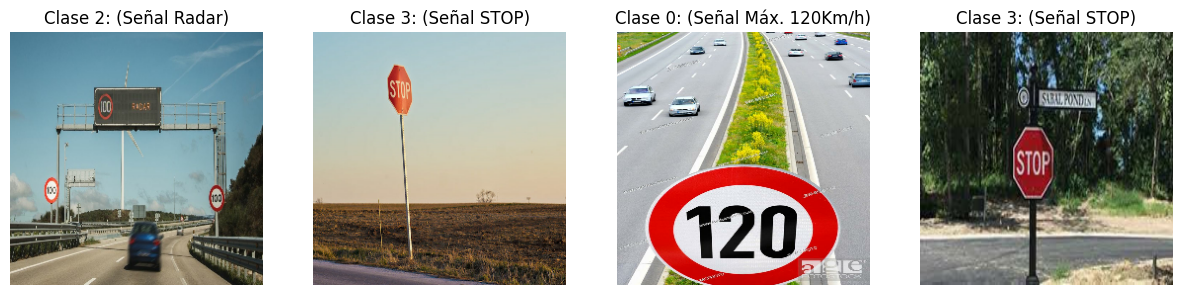

In [10]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)
for idx,img in enumerate(lote_datos[0][:4]):
    axs[idx].imshow(img.astype(np.uint8))
    clase = lote_datos[1][idx]
    axs[idx].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[idx].axis('off')

Definición de los conjuntos de imágenes para la creación del modelo:

In [14]:
size_entrenamiento = int(len(datos) * 0.7)
size_validacion = int(len(datos) * 0.15) + 1
size_test = int(len(datos) * 0.15) + 1

#len(datos) == size_entrenamiento + size_validacion + size_test

In [ ]:
particion_entrenamiento = datos.take(size_entrenamiento)
particion_validacion = datos.skip(size_entrenamiento).take(size_validacion)
particion_test = datos.skip(size_entrenamiento + size_validacion)

Creación del modelo:

In [ ]:
modelo  = Sequential() # Inicializar el modelo

In [ ]:
modelo.add(Conv2D(16, (3, 3),1 , activation='relu', input_shape=(256, 256, 3))) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(32, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(16, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Flatten()) # Aplanar la imagen

modelo.add(Dense(256, activation='relu')) # Capa densa
modelo.add(Dense(1, activation='sigmoid')) # Capa densa

In [ ]:
# Compilar el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Ver las estadísticas del modelo generado
modelo.summary()

NameError: name 'modelo' is not defined

Fase de entrenamiento:

In [17]:
# Seleccionar directorio para guardar los logs
logs_dir = 'logs'
tensorboard_callback = t.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

In [ ]:
# Entrenar el modelo y guardar los logs
hist = modelo.fit(particion_entrenamiento, validation_data=particion_validacion, epochs=20, callbacks=[tensorboard_callback])